In [1]:
# Installing required modules/models
%pip install lightgbm
%pip install catboost
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "intall" - maybe you meant "install"



In [2]:
# Importing libraries 
import numpy as np 
import pandas as pd 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

from sklearn.linear_model import Ridge, ElasticNet,  Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from datetime import datetime
import lightgbm
from lightgbm import LGBMRegressor
import xgboost as xg

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data import and df creation 
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_b = data.drop(['Id'], axis=1) 
test_b = test.drop(['Id'], axis=1) # We are removing the ID Index
data_b.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Analyse missing Values

data_b.isnull().sum().sort_values(ascending=False).head(20)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
MSSubClass         0
dtype: int64

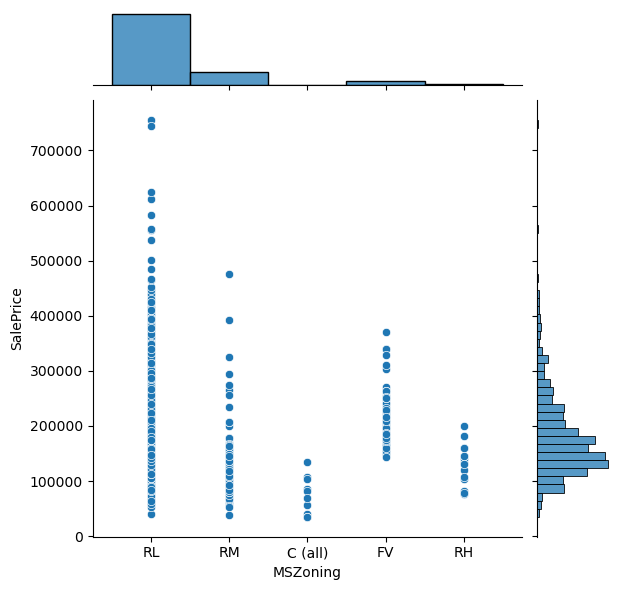


****INFO****
count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

****VALUE COUNTS****
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

****VALUE AVG SALE PRICE****
MSZoning
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275
Name: SalePrice, dtype: float64

****TEST INFO****
count     1455
unique       5
top         RL
freq      1114
Name: MSZoning, dtype: object

****VALUE COUNTS****
RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

Only in Train: []
Only in Test: []


In [5]:
# We analysed all features by user difined functions
# Plotting a joint plot to see outliers

def analyse_columns(feature_name):

    sns.jointplot(data=data_b, y="SalePrice", x=feature_name)
    plt.show()
    print("\n****INFO****")
    print(data_b[feature_name].describe())
    print("\n****VALUE COUNTS****")
    print(data_b[feature_name].value_counts())
    print("\n****VALUE AVG SALE PRICE****")
    print(data_b.groupby(feature_name)['SalePrice'].mean())
    if data_b[feature_name].dtype!="O":
        print("\nSkewness:",str(skew(data_b[feature_name])))

    print("\n****TEST INFO****")
    print(test_b[feature_name].describe())
    print("\n****VALUE COUNTS****")
    print(test_b[feature_name].value_counts())
    
    print("\nOnly in Train: "+str(list(set(data_b[feature_name].value_counts().index.values) - set(test_b[feature_name].value_counts().index.values))))
    print("Only in Test: "+ str(list(set(test_b[feature_name].value_counts().index.values) - set(data_b[feature_name].value_counts().index.values))))
    
analyse_columns("MSZoning")

In [6]:
# FILL MISSING VALUES AFTER ANALYSING EACH COLUMN
test_b['MSZoning']=test_b['MSZoning'].fillna("C (all)") 
test_b['GarageCars']=test_b['GarageCars'].fillna(0) 
test_b['GarageArea']=test_b['GarageArea'].fillna(0) 
test_b['Functional']=test_b['Functional'].fillna("Typ") 
test_b['SaleType']=test_b['SaleType'].fillna("WD") 
test_b['SaleCondition']=test_b['SaleCondition'].fillna("Normal")
data_b['Fence']=data_b['Fence'].fillna("None") 
test_b['Fence']=test_b['Fence'].fillna("None") 
data_b['Electrical'] = data_b['Electrical'].fillna("SBrkr")
data_b['FireplaceQu'] = data_b['FireplaceQu'].fillna("None")
test_b['FireplaceQu'] = test_b['FireplaceQu'].fillna("None")
data_b['GarageType'] = data_b['GarageType'].fillna("None")
test_b['GarageType'] = test_b['GarageType'].fillna("None")
data_b['GarageQual'] = data_b['GarageQual'].fillna("None")
test_b['GarageQual'] = test_b['GarageQual'].fillna("None")
data_b['GarageCond'] = data_b['GarageCond'].fillna("None")
test_b['GarageCond'] = test_b['GarageCond'].fillna("None")
data_b['GarageFinish'] = data_b['GarageFinish'].fillna("None")
test_b['GarageFinish'] = test_b['GarageFinish'].fillna("None")
test_b['Exterior1st'] = test_b['Exterior1st'].fillna("VinylSd")
test_b['Exterior2nd']= test_b['Exterior2nd'].fillna("VinylSd")
data_b['MasVnrType'] = data_b['MasVnrType'].fillna("None")
test_b['MasVnrType'] = test_b['MasVnrType'].fillna("None")
data_b['MasVnrArea'] = data_b['MasVnrArea'].fillna(0)
test_b['MasVnrArea'] = test_b['MasVnrArea'].fillna(0)
test_b['BsmtHalfBath']=test_b['BsmtHalfBath'].fillna(0) 
test_b['BsmtFullBath']=test_b['BsmtFullBath'].fillna(0) 
test_b['KitchenQual']=test_b['KitchenQual'].fillna("Gd") 
test_b['TotalBsmtSF']=test_b['TotalBsmtSF'].fillna(0) 
test_b['BsmtUnfSF']=test_b['BsmtUnfSF'].fillna(0)
test_b['BsmtFinSF1']=test_b['BsmtFinSF1'].fillna(0) 
test_b['BsmtFinSF2']= test_b['BsmtFinSF2'].fillna(0) 
test_b['BsmtQual']=test_b['BsmtQual'].fillna("None") 
data_b['BsmtQual']=data_b['BsmtQual'].fillna("None")
test_b['BsmtCond']= test_b['BsmtCond'].fillna("None")
data_b['BsmtCond']= data_b['BsmtCond'].fillna("None")
test_b['BsmtExposure']= test_b['BsmtExposure'].fillna("None") 
data_b['BsmtExposure']= data_b['BsmtExposure'].fillna("None") 
test_b['Utilities']= test_b['Utilities'].fillna("AllPub") 
data_b['GarageYrBlt'] = data_b['GarageYrBlt'].fillna(2000)
test_b['GarageYrBlt'] = test_b['GarageYrBlt'].fillna(2000)

In [7]:
test_b.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.0,57.378341,42.746880,20.0,20.0,50.0,70.0,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.0,67.0,80.0,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.0,9399.0,11517.5,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.0,6.0,7.0,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.0,5.0,6.0,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.0,1973.0,2001.0,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.0,1992.0,2004.0,2010.0
MasVnrArea,1459.0,99.673749,177.001792,0.0,0.0,0.0,162.0,1290.0
BsmtFinSF1,1459.0,438.902673,455.257119,0.0,0.0,350.0,752.0,4010.0
BsmtFinSF2,1459.0,52.583276,176.698671,0.0,0.0,0.0,0.0,1526.0


In [8]:
#Normalizing values of test data

test_b.loc[test.GarageYrBlt==2207,'GarageYrBlt'] = 2005  # mode value
test_b.loc[test_b.LotArea==1533,'LotFrontage'] = 21 # Minimum Value
test_b.loc[test_b.LotFrontage>130,'LotFrontage'] = 130
test_b.loc[test_b.LotArea>40000,'LotArea'] = 40000
test_b.loc[test_b["1stFlrSF"]>2200,'1stFlrSF'] = 2200
test_b.loc[test_b["GrLivArea"]>3000,'GrLivArea'] = 3000
test_b.loc[test_b["TotRmsAbvGrd"]>10,'TotRmsAbvGrd'] = 10
test_b.loc[test_b["BsmtFinSF1"]>2100,'BsmtFinSF1'] = 2100
test_b.loc[test_b["TotalBsmtSF"]>2500,'TotalBsmtSF'] = 2500
test_b.loc[test_b["GarageCars"]>3,'GarageCars'] = 3
test_b.loc[test_b["GarageArea"]>1000,'GarageArea'] = 1000

# Making a linear regression to fill missin LotFrontage values

test_b.loc[test_b["LotFrontage"].isnull(),["LotFrontage"]]=(test_b.loc[test_b["LotFrontage"].isnull(),["LotArea"]]*0.00885-15.17).values

In [9]:
data_b.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [10]:
#Normalizing values of train data

data_b.loc[data_b.LotArea>40000,'LotArea'] = 40000
data_b.loc[data_b.LotFrontage>150,'LotFrontage'] = 150
data_b.loc[data_b["1stFlrSF"]>3000,'1stFlrSF'] = 3000
data_b.loc[data_b["GrLivArea"]>4000,'GrLivArea'] = 4000
data_b.loc[data_b["TotRmsAbvGrd"]>10,'TotRmsAbvGrd'] = 10
data_b.loc[data_b["BsmtFinSF1"]>2200,'BsmtFinSF1'] = 2200
data_b.loc[data_b["TotalBsmtSF"]>2500,'TotalBsmtSF'] = 2500
data_b.loc[data_b["GarageCars"]>3,'GarageCars'] = 2 # mode value
data_b.loc[data_b["GarageArea"]>1000,'GarageArea'] = 1000


# Making a linear regression to fill missin LotFrontage values

data_b.loc[data_b["LotFrontage"].isnull(),["LotFrontage"]]=(data_b.loc[data_b["LotFrontage"].isnull(),["LotArea"]]*0.00885-15.17).values

In [11]:
# This line of code sets a variable cur_year to the current year using the datetime module
cur_year = datetime.now().year

#These two lines of code create a new feature called AllSF by adding the square footage of the basement (TotalBsmtSF) and the above ground living area (GrLivArea).
data_b['AllSF'] = data_b['TotalBsmtSF'] + data_b['GrLivArea']
test_b['AllSF'] = test_b['TotalBsmtSF'] + test_b['GrLivArea']

#These two lines of code create a new feature called RatioConstArea by calculating the ratio of constructed area to the total area of the lot. 
#The resulting values are rounded to 2 decimal places.
data_b['RatioConstArea'] = (data_b['AllSF'] / data_b['LotArea']).round(2)
test_b['RatioConstArea'] = (test_b['AllSF'] / test_b['LotArea']).round(2)

#These two lines of code create a new feature called Age_of_house by subtracting the year the house was built (YearBuilt) from the current year.
data_b["Age_of_house"] = cur_year - data_b["YearBuilt"]
test_b["Age_of_house"] = cur_year - test_b["YearBuilt"]

#These two lines of code create two new features called RemodAfter and AgeRemodAdd. 
#RemodAfter calculates the number of years between the year the house was remodeled (YearRemodAdd) and the year it was built (YearBuilt). 
#AgeRemodAdd calculates the number of years between the year the house was remodeled and the current year.
data_b["RemodAfter"] = data_b["YearRemodAdd"] - data_b["YearBuilt"]
data_b["AgeRemodAdd"] = cur_year - data_b["YearRemodAdd"]

#These three lines of code create two new features called RemodAfter and AgeRemodAdd for the test dataset.
#RemodAfter calculates the number of years between the year the house was remodeled (YearRemodAdd) and the year it was built (YearBuilt). 
#However, there is an additional line of code that sets any negative values of RemodAfter to 0. 
#AgeRemodAdd calculates the number of years between the year the house was remodeled and the current year.
test_b["RemodAfter"] = test_b["YearRemodAdd"] - test_b["YearBuilt"]
test_b.loc[test_b.RemodAfter<0,'RemodAfter'] = 0
test_b["AgeRemodAdd"] = cur_year - test_b["YearRemodAdd"]

#These three lines of code create a new feature called Age_Sold by subtracting the year the house was sold (YrSold) from the year it was built (YearBuilt). 
#There is also an additional line of code that sets any negative values of Age_Sold in the test dataset to 0.
data_b["Age_Sold"] = data_b["YrSold"] - data_b["YearBuilt"] 
test_b["Age_Sold"] = test_b["YrSold"] - test_b["YearBuilt"]
test_b.loc[test_b.Age_Sold<0,'Age_Sold'] = 0


data_b["Sold_before"] = cur_year - data_b["YrSold"]
test_b["Sold_before"] = cur_year - test_b["YrSold"] 

data_b['Age_Garage'] = cur_year - data_b['GarageYrBlt']
test_b['Age_Garage'] = cur_year - test_b['GarageYrBlt']
data_b['Age_Garage_Sold'] = data_b["YrSold"] - data_b['GarageYrBlt']
test_b['Age_Garage_Sold'] = test_b["YrSold"] - test_b['GarageYrBlt']

data_b['TotalPorchArea']=data_b['EnclosedPorch'] + data_b['OpenPorchSF'] + data_b['ScreenPorch'] + data_b['3SsnPorch'] 
test_b['TotalPorchArea']=test_b['EnclosedPorch'] + test_b['OpenPorchSF'] + test_b['ScreenPorch'] + test_b['3SsnPorch'] 

data_b['TotalBathNos'] = data_b['FullBath']+ data_b['HalfBath']+ data_b['BsmtFullBath']+ data_b['BsmtHalfBath']
test_b['TotalBathNos'] = test_b['FullBath']+ test_b['HalfBath']+ test_b['BsmtFullBath']+ test_b['BsmtHalfBath']

In [12]:
#Replacing values that are outliers in both datasets
test_b['MSSubClass'] = test_b['MSSubClass'].replace(["150"], ["160"])
data_b['HouseStyle'] = data_b['HouseStyle'].replace(["2.5Fin"], ["2Story"])
data_b['Exterior1st'] = data_b['Exterior1st'].replace(['Stone', 'ImStucc'],['CemntBd', 'Stucco'])
data_b['Electrical'] = data_b['Electrical'].replace(["Mix","FuseF","FuseP"], ["SBrkr","FuseA","FuseA"])
test_b['Electrical'] = test_b['Electrical'].replace(["Mix","FuseF","FuseP"], ["SBrkr","FuseA","FuseA"])
test_b['BsmtCond'] = test_b['BsmtCond'].replace(["Ex"], ["Gd"])
data_b['GarageQual'] = data_b['GarageQual'].replace(["Ex"], ["Gd"])
data_b['GarageCond'] = data_b['GarageCond'].replace(["Ex"], ["Gd"])
test_b['GarageCond'] = test_b['GarageCond'].replace(["Ex"], ["Gd"])

In [13]:
#creating the Y variable for the analysis
y = data_b.pop("SalePrice")

In [14]:
#After the changes in the data, with this we will verify the null values
data_b.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
BsmtFinType2      38
BsmtFinType1      37
MSSubClass         0
PavedDrive         0
GarageCond         0
GarageQual         0
GarageArea         0
dtype: int64

In [15]:
#After the changes in the data, with this we will verify the null values
test_b.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1456
MiscFeature     1408
Alley           1352
BsmtFinType2      42
BsmtFinType1      42
MSSubClass         0
PavedDrive         0
GarageCond         0
GarageQual         0
GarageArea         0
dtype: int64

In [16]:
#dropping the unnecessary columns that have nulls
data_b = data_b.dropna(axis=1) 
test_b = test_b.dropna(axis=1)

In [17]:
#dropping the columns that were used for the creation of the new variables
#steps before this
data_b = data_b.drop(["YearBuilt","YearRemodAdd","Street","RoofMatl","Condition2","LowQualFinSF","Exterior2nd","OpenPorchSF","EnclosedPorch",
                    "3SsnPorch","ScreenPorch","PoolArea","MiscVal","YrSold","Utilities","Heating","KitchenAbvGr","GarageYrBlt"], axis=1) 
test_b = test_b.drop(["YearBuilt","YearRemodAdd","Street","RoofMatl","Condition2","LowQualFinSF","Exterior2nd","OpenPorchSF","EnclosedPorch",
                    "3SsnPorch","ScreenPorch","PoolArea","MiscVal","YrSold","Utilities","Heating", "KitchenAbvGr","GarageYrBlt"], axis=1) 

In [18]:
#Loop that splits the numerical from the categorical. This to create dummies for the categorical
cols = data_b.columns
numeric_columns, categorical_columns = [], []
for i in range(len(cols)):
    if data_b[cols[i]].dtypes == 'O':
        categorical_columns.append(cols[i])
    else:
        numeric_columns.append(cols[i])

In [19]:
# getting dummies for both datasets
data_b = pd.get_dummies(data_b)
test_b = pd.get_dummies(test_b)

In [20]:
# Skewing all features (Log level transform)
skewed_feats = data_b.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

#deep copying data into new dataframe 
data_b_skewed = data_b.copy()
test_b_skewed = test_b.copy()

skewness = skewness[abs(skewness) > 1]
print("There are {} skewed numerical features to transform".format(skewness.shape[0]))

#converting actual values into log values in column for each columns of the data frame
#and storting it into data and test
skewed_features = skewness.index
for feat in skewed_features:
    data_b_skewed[feat] = np.log1p(data_b_skewed[feat])
    test_b_skewed[feat] = np.log1p(test_b_skewed[feat])

There are 225 skewed numerical features to transform


In [21]:
#Determining if there are swede values in the data
print("Only in Train: "+ str(list(set(data_b_skewed.columns) - set(test_b_skewed.columns))))
print("Only in Test: "+ str(list(set(test_b_skewed.columns) - set(data_b_skewed.columns))))

Only in Train: []
Only in Test: []


In [22]:
# converting the actual values of sales price into log values
y_log = np.log1p(y)

In [23]:
#Converting the -INF values into 0
test_b_skewed=test_b_skewed.replace(-np.Inf, 0)

In [24]:
#running cross valuation scores for different regression models
def models(X,y):
    
    #ElasticNet regression
    baseline = ElasticNet(random_state=0,max_iter=10e7,alpha=0.0003)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("ENet avg:",np.mean(baseline_score))
    
    #Ridge Regression
    baseline = Ridge(alpha = 1, random_state=0)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("Ridge avg:",np.mean(baseline_score))   
    
    #Lasso regression
    baseline = Lasso(alpha = 0.0001,random_state=0)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("Lasso avg:",np.mean(baseline_score))
    
    #KernelRidge regression
    baseline = KernelRidge(alpha=0.1)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("KRR avg:",np.mean(baseline_score))
    
    #LGBMR  regression
    baseline = LGBMRegressor(learning_rate=0.01,num_leaves=4,n_estimators=2000, random_state=0)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("LGBM avg:",np.mean(baseline_score))
    
    #XGB Regression
    baseline = xg.XGBRegressor(learning_rate=0.01,n_estimators=2000, subsample=0.7,colsample_bytree=0.7,random_state=0)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("XGB avg:",np.mean(baseline_score))
    
    #Catboost regression
    baseline = CatBoostRegressor(random_state=0,verbose=0)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("CatB avg:",np.mean(baseline_score))
    
    #Gradient Boost regression
    baseline = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.02,max_depth=4, max_features='sqrt',
                min_samples_leaf=15, min_samples_split=50,loss='huber', random_state = 0)
    baseline_score = cross_val_score(baseline, X, y, cv=10)
    print("GBR avg:",np.mean(baseline_score))
    
models(data_b_skewed,y_log)  

ENet avg: 0.9081423769455832
Ridge avg: 0.9030750344201939
Lasso avg: 0.9054133981153164
KRR avg: 0.8946640870310489
LGBM avg: 0.9005330771094776
XGB avg: 0.9139168117227585
CatB avg: 0.914869479102849
GBR avg: 0.9087245630873504


In [25]:
#using 6 models with the highest values in the previous step 
def submission(X_train, y_train, X_test):    
    sub_df = pd.read_csv('sample_submission.csv', index_col = "Id")
    
    ridge = Ridge(alpha = 1, random_state=0).fit(X_train,y_train)
    ridge_preds_log=ridge.predict(X_test)
    
    lasso = Lasso(alpha = 0.0001,random_state=0).fit(X_train,y_train)
    lasso_preds_log=lasso.predict(X_test)

    catB = CatBoostRegressor(random_state=0,verbose=0).fit(X_train,y_train)
    catB_preds_log=catB.predict(X_test)

    xgb = xg.XGBRegressor(learning_rate=0.01,n_estimators=2000, subsample=0.7,colsample_bytree=0.7,random_state=0).fit(X_train,y_train)
    xgb_preds_log=xgb.predict(X_test)

    lgbm = LGBMRegressor(n_estimators=2000,learning_rate=0.01,subsample=0.7,random_state=0).fit(X_train,y_train) 
    lgbm_preds_log=lgbm.predict(X_test) 
    
    gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01,subsample=0.7,random_state=0).fit(X_train, y_train) 
    gbr_preds_log=gbr.predict(X_test)
        
    catb_xbr_lasso_ridge_mean_preds_log=(catB_preds_log+ridge_preds_log+lasso_preds_log+xgb_preds_log+lgbm_preds_log+gbr_preds_log)/6
    sub_df['SalePrice'] = np.exp(catb_xbr_lasso_ridge_mean_preds_log)-1
    sub_df.to_csv("Team_12_HULT_Boston_submission.csv")
    
submission(data_b_skewed,y_log,test_b_skewed)